In [45]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as plticker
from lightning.evaluation import *
import pickle
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
from itertools import cycle
from sklearn import metrics
import shutil
import csv
CM_TO_INCH = 1.0/2.5

/tmp/ipykernel_9108/2233769697.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


In [46]:
with open('comments.pickle', 'rb') as f:
    comments = pickle.load(f)
with open('scores.pickle', 'rb') as f:
    scores = pickle.load(f)
with open('qualities.pickle', 'rb') as f:
    qualities = pickle.load(f)
with open('datasets.pickle', 'rb') as f:
    datasets = pickle.load(f)
datasets_names = {
    'iris_verification_NDCSI2013_01_05': 'N. D. 2013',
    'iris_verification_nd_0405_01_01': 'N. D. 0405',
    'iris_verification_inno_keymaker_01_01': 'Innovatrics',
    'iris_verification_iitd_01_01': 'IITD',
}

In [102]:
def matplotlib_plot_det(fmr, fnmr, ax, label="", fontsize=12, fontname='DejaVu Sans', linestyle='-', axis_range=(0.5,0.5)):
    x = np.array(stats.norm.ppf(fmr))
    y = np.array(stats.norm.ppf(fnmr))
    ax.plot(x, y, label=label, linestyle=linestyle)
    ticks = [0.001,0.004,0.01, 0.023, 0.05, 0.1, 0.20, 0.35, 0.5, 0.80, 0.95, 0.99, 0.999]
    tick_locations = stats.norm.ppf(ticks)
    tick_labels = [
        "{:.0f}".format(s*100) if (100 * s).is_integer() else "{:.1f}".format(s*100)
        for s in ticks
    ]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(tick_labels, fontsize=fontsize, fontname=fontname)
    ax.set_xlim(-3.5, stats.norm.ppf(axis_range[0]))
    ax.set_yticks(tick_locations)
    ax.set_yticklabels(tick_labels, fontsize=fontsize, fontname=fontname)
    ax.set_ylim(-3.5, stats.norm.ppf(axis_range[0]))
def plot_dets_reject_rate(
    scores_selector, score_title,
    quality_selector_dict,
    iir=0.1, fontsize=12, offset_legend=0.11, ncol=2, axis_range=(0.5,0.5)
):
    global scores, datasets, datasets_names
    fontname='DejaVu Serif'
    auc_table= {}
    fig, axs = plt.subplots(2, 2, figsize=(CM_TO_INCH*15, 12*CM_TO_INCH), sharex=True, sharey=True)
    axs = axs.flatten()
    axs_dict = dict(zip(datasets.keys(), axs))
    axs_style_cycle = {d: cycle(['-', '--', ':', '-.']) for d in axs_dict}
        
    run_name = comments[scores_selector][0]
    run_comment = comments[scores_selector][1]
    print(run_name, ':', run_comment)
    for dataset in datasets:
        labels, sc, pairs = generate_labels_scores(
            scores[dataset+'+'+scores_selector]['pairs'], 
            scores[dataset+'+'+scores_selector]['impostors']
        )
        sc=-sc
        fmr, fnmr, treashold = det_curve(labels, sc)
        print(f'    {dataset} AUC: {metrics.auc(fmr, fnmr):.4e}')
        if not dataset in auc_table:
            auc_table[dataset] = {}
        auc_table[dataset][score_title] = metrics.auc(fmr, fnmr)
        matplotlib_plot_det(
            fmr=fmr, fnmr=fnmr, ax=axs_dict[dataset], label=score_title, 
            fontsize=fontsize, fontname=fontname, 
            linestyle=next(axs_style_cycle[dataset]),
            axis_range=axis_range
        )

        for run, label in quality_selector_dict.items():
            labels, sc, quality_scores = generate_sorted_labels_scores_quality(
                scores[dataset+'+'+scores_selector]['pairs'], 
                scores[dataset+'+'+scores_selector]['impostors'], 
                qualities[dataset+'+'+run]
            )
            sc = -sc
            fmr, fnmr, treashold = list(det_for_irrs(labels, sc, [iir]))[0][1]
            auc_table[dataset][label] = metrics.auc(fmr, fnmr)
            matplotlib_plot_det(
                fmr=fmr, fnmr=fnmr, ax=axs_dict[dataset], label=label, 
                fontsize=fontsize, fontname=fontname, 
                linestyle=next(axs_style_cycle[dataset]),
                axis_range=axis_range
            )
    
    for dataset, ax in axs_dict.items():
        ax.set_title(datasets_names[dataset], loc='center', fontsize=fontsize, fontname=fontname, y=1.0, pad=-12, backgroundcolor='white')
        ax.grid(True)
    axs[2].set_xlabel('FMR [%]',fontsize=fontsize, fontname=fontname)
    axs[3].set_xlabel('FMR [%]',fontsize=fontsize, fontname=fontname)
    axs[0].set_ylabel('FNMR [%]',fontsize=fontsize, fontname=fontname)
    axs[2].set_ylabel('FNMR [%]',fontsize=fontsize, fontname=fontname)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.tight_layout()
    fig.subplots_adjust(bottom=offset_legend*2)
    fig.legend(handles, labels, loc='lower center', ncol=ncol, prop={'family':fontname, 'size':fontsize})
    return fig, auc_table
def plot_scores(scores_selector_dict, fontsize=12, offset_legend=0.11, ncol=2, axis_range=(0.5,0.5)):
    global scores, datasets, datasets_names
    fontname='DejaVu Serif'
    auc_table= {}
    fmnr_table= {}
    fig, axs = plt.subplots(2, 2, figsize=(CM_TO_INCH*15, 12*CM_TO_INCH), sharex=True, sharey=True)
    axs = axs.flatten()
    axs_dict = dict(zip(datasets.keys(), axs))
    axs_style_cycle = {d: cycle(['-', '--', ':', '-.']) for d in axs_dict}
    for run, label in scores_selector_dict.items():
        run_name = comments[run][0]
        run_comment = comments[run][1]
        print(run_name, ':', run_comment)
        for dataset in datasets:
            labels, sc, pairs = generate_labels_scores(scores[dataset+'+'+run]['pairs'], scores[dataset+'+'+run]['impostors'])
            sc=-sc
            fmr, fnmr, treashold = det_curve(labels, sc)
            print(f'    {dataset} AUC: {metrics.auc(fmr, fnmr):.4e}')
            print(f'    {dataset} FNMR@FMR=0.001: {fmr[np.argmin(np.abs(fmr - 0.001))]:.4e}')
            if not dataset in auc_table:
                auc_table[dataset] = {}
            auc_table[dataset][scores_selector_dict[run]] = metrics.auc(fmr, fnmr)
            if not dataset in fmnr_table:
                fmnr_table[dataset] = {}
            fmnr_table[dataset][scores_selector_dict[run]] = float(fnmr[np.argmin(np.abs(fmr - 0.001))])

            matplotlib_plot_det(
                fmr=fmr, fnmr=fnmr, ax=axs_dict[dataset], label=label, 
                fontsize=fontsize, fontname=fontname, 
                linestyle=next(axs_style_cycle[dataset]),
                axis_range=axis_range
            )
    for dataset, ax in axs_dict.items():
        ax.set_title(datasets_names[dataset], loc='center', fontsize=fontsize, fontname=fontname, y=1.0, pad=-12, backgroundcolor='white')
        ax.grid(True)
    axs[2].set_xlabel('FMR [%]',fontsize=fontsize, fontname=fontname)
    axs[3].set_xlabel('FMR [%]',fontsize=fontsize, fontname=fontname)
    axs[0].set_ylabel('FNMR [%]',fontsize=fontsize, fontname=fontname)
    axs[2].set_ylabel('FNMR [%]',fontsize=fontsize, fontname=fontname)
    handles, labels = axs[0].get_legend_handles_labels()
    fig.tight_layout()
    fig.subplots_adjust(bottom=offset_legend*2)
    fig.legend(handles, labels, loc='lower center', ncol=ncol, prop={'family':fontname, 'size':fontsize})
    return fig, auc_table, fmnr_table
def latex_float(f):
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
def table_fmt(tab):
    keyls = None
    #print('\\multicolumn{5}{c}{\\textbf{Plochy pod DET krivkami}}} \\\\ \\hline')
    print("$[\\times 10^{-4}]$",end='')
    for ds in tab:
        keyls = list(tab[ds].keys())
        keyls.sort()
        print(f' & \\textbf{{{datasets_names[ds]}}}', end='')
    print('\\\\ \\hline \\hline ')
    for key in keyls:
        print(f'{key}', end='')
        for ds in tab:
            print(f' & {tab[ds][key]*1e4:.2f}', end='')
        print(' \\\\ \\hline')

RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
    iris_verification_iitd_01_01 AUC: 1.0601e-04
    iris_verification_iitd_01_01 FNMR@FMR=0.001: 9.9597e-04
    iris_verification_inno_keymaker_01_01 AUC: 2.0537e-02
    iris_verification_inno_keymaker_01_01 FNMR@FMR=0.001: 1.0065e-03
    iris_verification_nd_0405_01_01 AUC: 6.2603e-05
    iris_verification_nd_0405_01_01 FNMR@FMR=0.001: 1.0045e-03
    iris_verification_NDCSI2013_01_05 AUC: 9.7523e-05
    iris_verification_NDCSI2013_01_05 FNMR@FMR=0.001: 1.0056e-03
RecognitionNet-iresnet50-MagFaceLoss-DaqKXb : Crop baseline with MagFace, without fully connected layer
    iris_verification_iitd_01_01 AUC: 4.9227e-04
    iris_verification_iitd_01_01 FNMR@FMR=0.001: 9.9597e-04
    iris_verification_inno_keymaker_01_01 AUC: 7.0723e-02
    iris_verification_inno_keymaker_01_01 FNMR@FMR=0.001: 1.0065e-03
    iris_verification_nd_0405_01_01 AUC: 5.5030e-04
    iris_verification_nd_0405_01_01 FNMR@FMR=0.001: 1.0045e-03
    iris_ver

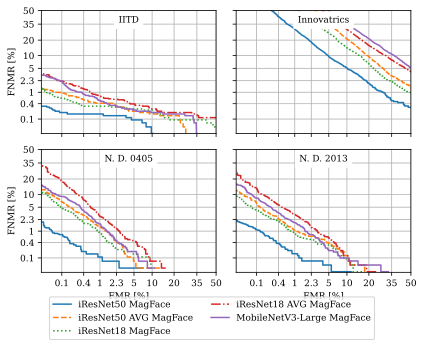

In [101]:
fig, tab, tab2 = plot_scores({
'JnGKXb' : 'iResNet50 MagFace',
'DaqKXb' : 'iResNet50 AVG MagFace',
'7B0TXb' : 'iResNet18 MagFace',
'YuBXXb' : 'iResNet18 AVG MagFace',
'PUXTXb' : 'MobileNetV3-Large MagFace',
}, fontsize=9, offset_legend=0.10)
table_fmt(tab2)

RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
    iris_verification_iitd_01_01 AUC: 1.0601e-04
    iris_verification_iitd_01_01 FNMR@FMR=0.001: 9.9597e-04
    iris_verification_inno_keymaker_01_01 AUC: 2.0537e-02
    iris_verification_inno_keymaker_01_01 FNMR@FMR=0.001: 1.0065e-03
    iris_verification_nd_0405_01_01 AUC: 6.2603e-05
    iris_verification_nd_0405_01_01 FNMR@FMR=0.001: 1.0045e-03
    iris_verification_NDCSI2013_01_05 AUC: 9.7523e-05
    iris_verification_NDCSI2013_01_05 FNMR@FMR=0.001: 1.0056e-03
RecognitionNet-magiresnet50-ArcFaceLoss-arzKXb : Croped ArcFace
    iris_verification_iitd_01_01 AUC: 2.3130e-04
    iris_verification_iitd_01_01 FNMR@FMR=0.001: 9.9597e-04
    iris_verification_inno_keymaker_01_01 AUC: 3.4915e-02
    iris_verification_inno_keymaker_01_01 FNMR@FMR=0.001: 1.0065e-03
    iris_verification_nd_0405_01_01 AUC: 1.4825e-04
    iris_verification_nd_0405_01_01 FNMR@FMR=0.001: 1.0045e-03
    iris_verification_NDCSI2013_01_05 AUC: 3.0991e-0

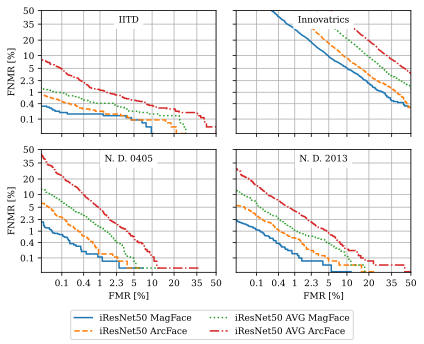

In [97]:
fig, tab, tab2 = plot_scores({
'JnGKXb' : 'iResNet50 MagFace',
'arzKXb' : 'iResNet50 ArcFace',
'DaqKXb' : 'iResNet50 AVG MagFace',
'UVyKXb' : 'iResNet50 AVG ArcFace',
}, fontsize=9, offset_legend=0.10)
fig.savefig('plots/arcface_vs_magface.pdf')
table_fmt(tab)
table_fmt(tab2)

RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
    iris_verification_iitd_01_01 AUC: 1.0601e-04
    iris_verification_inno_keymaker_01_01 AUC: 2.0537e-02
    iris_verification_nd_0405_01_01 AUC: 6.2603e-05
    iris_verification_NDCSI2013_01_05 AUC: 9.7523e-05
RecognitionNet-magiresnet50-ArcFaceLoss-arzKXb : Croped ArcFace
    iris_verification_iitd_01_01 AUC: 2.3130e-04
    iris_verification_inno_keymaker_01_01 AUC: 3.4915e-02
    iris_verification_nd_0405_01_01 AUC: 1.4825e-04
    iris_verification_NDCSI2013_01_05 AUC: 3.0991e-04
RecognitionNet-magiresnet50-ArcFaceLoss-RMdMXb : Unwraped ArcFace
    iris_verification_iitd_01_01 AUC: 9.0503e-04
    iris_verification_inno_keymaker_01_01 AUC: 5.7704e-02
    iris_verification_nd_0405_01_01 AUC: 7.0595e-04
    iris_verification_NDCSI2013_01_05 AUC: 5.9777e-04
RecognitionNet-magiresnet50-MagFaceLoss-ihfMXb : Unwrap baseline
    iris_verification_iitd_01_01 AUC: 3.7796e-04
    iris_verification_inno_keymaker_01_01 AUC: 4.9762e

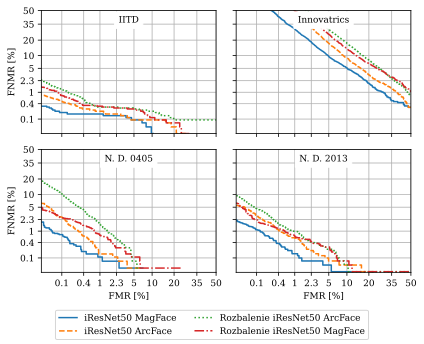

In [63]:
fig, tab = plot_scores({
'JnGKXb' : 'iResNet50 MagFace',
'arzKXb' : 'iResNet50 ArcFace',
'RMdMXb' : 'Rozbalenie iResNet50 ArcFace',
'ihfMXb' : 'Rozbalenie iResNet50 MagFace',
}, fontsize=9, ncol=2, offset_legend=0.10)
fig.savefig('plots/crop_vs_unwrap.pdf')
table_fmt(tab)

RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
    iris_verification_iitd_01_01 AUC: 1.0601e-04
    iris_verification_inno_keymaker_01_01 AUC: 2.0537e-02
    iris_verification_nd_0405_01_01 AUC: 6.2603e-05
    iris_verification_NDCSI2013_01_05 AUC: 9.7523e-05
RecognitionNet-magiresnet50-MagFaceLoss-vfFRXb : Shear + translate
    iris_verification_iitd_01_01 AUC: 2.7820e-04
    iris_verification_inno_keymaker_01_01 AUC: 2.2956e-02
    iris_verification_nd_0405_01_01 AUC: 1.3343e-04
    iris_verification_NDCSI2013_01_05 AUC: 1.6334e-04
RecognitionNet-magiresnet50-MagFaceLoss-931RXb : No augment
    iris_verification_iitd_01_01 AUC: 2.5900e-04
    iris_verification_inno_keymaker_01_01 AUC: 2.3803e-02
    iris_verification_nd_0405_01_01 AUC: 2.4565e-04
    iris_verification_NDCSI2013_01_05 AUC: 8.2558e-04
$[\times 10^{-4}]$ & \textbf{IITD} & \textbf{Innovatrics} & \textbf{N. D. 0405} & \textbf{N. D. 2013}\\ \hline \hline 
iResNet50 MagFace & 1.06 & 205.37 & 0.63 & 0.98 \\ \

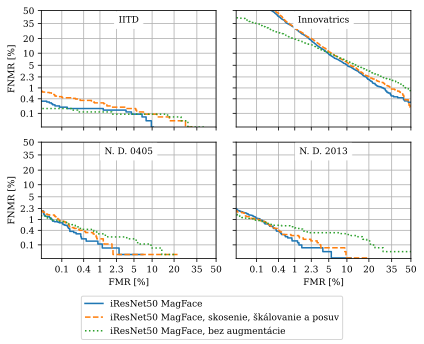

In [68]:
fig, table = plot_scores({
'JnGKXb' : 'iResNet50 MagFace',
'vfFRXb' : 'iResNet50 MagFace, skosenie, škálovanie a posuv',
'931RXb' : 'iResNet50 MagFace, bez augmentácie',
}, fontsize=9, offset_legend=0.12, ncol=1)
fig.savefig('plots/augment_vs_no_augment.pdf')
table_fmt(table)

RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
    iris_verification_iitd_01_01 AUC: 1.0601e-04
    iris_verification_inno_keymaker_01_01 AUC: 2.0537e-02
    iris_verification_nd_0405_01_01 AUC: 6.2603e-05
    iris_verification_NDCSI2013_01_05 AUC: 9.7523e-05
RecognitionNet-magiresnet18-MagFaceLoss-7B0TXb : Showcase of wrong schedule settings
    iris_verification_iitd_01_01 AUC: 7.0932e-04
    iris_verification_inno_keymaker_01_01 AUC: 4.9725e-02
    iris_verification_nd_0405_01_01 AUC: 4.3009e-04
    iris_verification_NDCSI2013_01_05 AUC: 5.3145e-04
RecognitionNet-iresnet18-MagFaceLoss-YuBXXb : iResNet18, crop, without fully connected layer
    iris_verification_iitd_01_01 AUC: 1.4354e-03
    iris_verification_inno_keymaker_01_01 AUC: 1.0319e-01
    iris_verification_nd_0405_01_01 AUC: 1.4683e-03
    iris_verification_NDCSI2013_01_05 AUC: 1.4292e-03
RecognitionNet-mobilenetv3_large-MagFaceLoss-PUXTXb : Small MobileNetV3, baseline crop, without fully connected layer
  

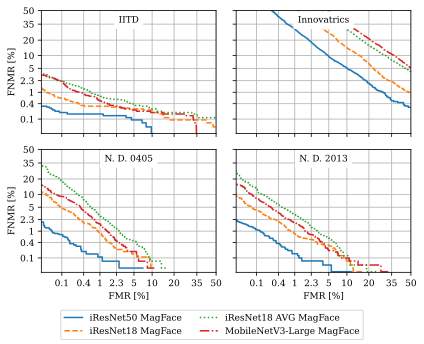

In [65]:
fig, tab = plot_scores({
'JnGKXb' : 'iResNet50 MagFace',
'7B0TXb' : 'iResNet18 MagFace',
'YuBXXb' : 'iResNet18 AVG MagFace',
'PUXTXb' : 'MobileNetV3-Large MagFace',
}, fontsize=9, offset_legend=0.10)
fig.savefig('plots/small_vs_large.pdf')
table_fmt(tab)

CrFiqaNet-iresnet18-CrFiqaLoss-imOXXb : Trained well, gives results, certainty ratio
    iris_verification_iitd_01_01 AUC: 9.8254e-04
    iris_verification_iitd_01_01 FNMR@FMR=0.001: 9.9597e-04
    iris_verification_inno_keymaker_01_01 AUC: 8.9373e-02
    iris_verification_inno_keymaker_01_01 FNMR@FMR=0.001: 1.0065e-03
    iris_verification_nd_0405_01_01 AUC: 1.1026e-03
    iris_verification_nd_0405_01_01 FNMR@FMR=0.001: 1.0045e-03
    iris_verification_NDCSI2013_01_05 AUC: 1.2954e-03
    iris_verification_NDCSI2013_01_05 FNMR@FMR=0.001: 1.0056e-03
CrFiqaNet-iresnet50-CrFiqaLoss-GzGNXb : Trained well, gives results, certainty ratio
    iris_verification_iitd_01_01 AUC: 5.4211e-04
    iris_verification_iitd_01_01 FNMR@FMR=0.001: 9.9597e-04
    iris_verification_inno_keymaker_01_01 AUC: 7.7554e-02
    iris_verification_inno_keymaker_01_01 FNMR@FMR=0.001: 1.0065e-03
    iris_verification_nd_0405_01_01 AUC: 8.6131e-04
    iris_verification_nd_0405_01_01 FNMR@FMR=0.001: 1.0045e-03
    iris_

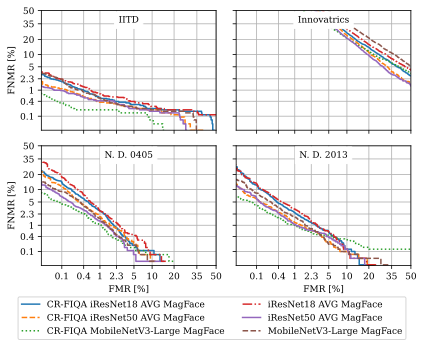

In [104]:
fig, tab, tab2 = plot_scores({
'imOXXb': 'CR-FIQA iResNet18 AVG MagFace',
'GzGNXb': 'CR-FIQA iResNet50 AVG MagFace',
'0IRWXb': 'CR-FIQA MobileNetV3-Large MagFace',
'YuBXXb': 'iResNet18 AVG MagFace',
'DaqKXb': 'iResNet50 AVG MagFace',
'PUXTXb': 'MobileNetV3-Large MagFace',
}, fontsize=9, offset_legend=0.11)
fig.savefig('plots/cr_fiqua_recognition.pdf')
table_fmt(tab)

In [9]:
def irrs_for_baseline(baseline, axs_dict, scores_selector_dict, dataset_fmr_dict, fontsize=12, offset_legend=0.11, fontname='DejaVu Serif', printout_iir=0.1):
    global qualities, scores, datasets, datasets_names
    baseline_fnmr = None
    axs_style_cycle = {d: cycle(['-', '--', ':', '-.']) for d in axs_dict}
    for run, label in scores_selector_dict.items():
        run_name = comments[run.split('+')[0]][0]
        run_comment = comments[run.split('+')[0]][1]
        print(run_name, ':', run_comment)
        for dataset in datasets:
            labels_sorted, sc_sorted, quality_scores = generate_sorted_labels_scores_quality(scores[dataset+'+'+baseline]['pairs'], scores[dataset+'+'+baseline]['impostors'], qualities[dataset+'+'+run])
            sc_sorted=-sc_sorted
            irr, fnmr = fnmr_at_irr(labels_sorted, sc_sorted, max_reject_rate=0.2, fmr_anchor=dataset_fmr_dict[dataset])
            print('   ', baseline, fnmr[0]*100, '%',fnmr[np.argmin(np.abs(np.array(irr) - printout_iir))]*100, '%')

            baseline_fnmr = fnmr[0]
            fnmr = fnmr/baseline_fnmr
            axs_dict[dataset].plot(np.array(irr)*100, np.array(fnmr)*100, label=label, linestyle=next(axs_style_cycle[dataset]))
    return baseline_fnmr

def irrs_for_baselines(baselines, scores_selector_dict, dataset_fmr_dict, fontsize=12, offset_legend=0.11, fontname='DejaVu Serif', ncol=2, printout_iir=0.1):
    global qualities, scores, datasets, datasets_names
    fig, axs = plt.subplots(4, len(baselines), figsize=(CM_TO_INCH*15, 16*CM_TO_INCH), sharex=True, sharey='row')
    baselises_list = list(baselines.keys())
    baselises_fnmrs = {}
    baselises_list.sort()
    dataset_list = list(datasets.keys())
    dataset_list.sort()
    axs_dict = {b: {d: axs[i, j] for i, d in enumerate(dataset_list)} for j, b in enumerate(baselises_list)}
    #print(axs_dict)
    for b in axs_dict:
        print(b)
        baselises_fnmrs[b] = irrs_for_baseline(b, axs_dict[b], scores_selector_dict, dataset_fmr_dict, fontsize=fontsize, offset_legend=offset_legend, fontname=fontname, printout_iir=printout_iir)
    for d in dataset_list:
        for b in baselises_list:
            ax = axs_dict[b][d]
            #ax.xaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
            ax.xaxis.set_major_locator(plticker.MultipleLocator(base=5.0))
            #ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
            ax.grid(True)
            for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
                tick.label.set_fontname(fontname)
                tick.label.set_fontsize(fontsize)
    for d in dataset_list:
        b = baselises_list[0]
        ax = axs_dict[b][d]
        ax.set_ylabel(f'{datasets_names[d]}\nRelatívna. hodnota\nFNMR[%]@\nFMR={dataset_fmr_dict[d]*100:.2f}%', fontsize=fontsize, fontname=fontname)
    d = dataset_list[-1]
    for b in baselises_list:
        ax = axs_dict[b][d]
        ax.set_xlabel(f'IRR [%]', fontsize=fontsize, fontname=fontname)
        ax.set_xticklabels([f'{t:.0f}' for t in ax.get_xticks()], fontsize=fontsize, fontname=fontname)

    d = dataset_list[0]
    for b in baselises_list:
        ax = axs_dict[b][d]
        ax.set_title(f'{baselines[b]}', fontsize=fontsize, fontname=fontname)

    handles, labels = axs[0][0].get_legend_handles_labels()
    fig.tight_layout()
    fig.subplots_adjust(bottom=offset_legend)
    fig.legend(handles, labels, loc='lower center', ncol=ncol, prop={'family':fontname, 'size':fontsize})
    return fig

def plot_irrs(baseline_run, scores_selector_dict, dataset_fmr_dict, fontsize=12, offset_legend=0.11, fontname='DejaVu Serif', ncol=2):
    global qualities, scores, datasets, datasets_names
    fig, axs = plt.subplots(4, 1, figsize=(CM_TO_INCH*15, 22*CM_TO_INCH))
    axs = axs.flatten()
    axs_dict = dict(zip(datasets.keys(), axs))
    print(axs_dict)
    irrs_for_baseline(baseline_run, axs_dict, scores_selector_dict, dataset_fmr_dict, fontsize=fontsize, offset_legend=offset_legend, fontname=fontname)
    for dataset, ax in axs_dict.items():
        ax.set_ylabel(f'FNMR@FMR={dataset_fmr_dict[dataset]*100:.2}%', fontsize=fontsize, fontname=fontname)
        #ax.xaxis.set_major_formatter(mtick.PercentFormatter())
        #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
        ax.set_title(datasets_names[dataset], fontsize=fontsize, fontname=fontname)
        ax.grid(True)
    axs[-1].set_xlabel('Percento odmietnutých párov', fontsize=fontsize, fontname=fontname)
    handles, labels = axs[0].get_legend_handles_labels()
    #fig.tight_layout()
    fig.subplots_adjust(bottom=offset_legend)
    fig.legend(handles, labels, loc='lower center', ncol=ncol, prop={'family':fontname, 'size':fontsize})
    return fig

RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
    iris_verification_iitd_01_01 AUC: 1.0601e-04
    iris_verification_inno_keymaker_01_01 AUC: 2.0537e-02
    iris_verification_nd_0405_01_01 AUC: 6.2603e-05
    iris_verification_NDCSI2013_01_05 AUC: 9.7523e-05
$[\times 10^{-4}]$ & \textbf{IITD} & \textbf{Innovatrics} & \textbf{N. D. 0405} & \textbf{N. D. 2013}\\ \hline \hline 
Magnitúda iResNet50 MagFace & 0.03 & 133.38 & 0.28 & 0.30 \\ \hline
SDD-FIQA iResNet50 MagFace & 0.03 & 185.31 & 0.62 & 0.24 \\ \hline
SER-FIQ iResNet18 MagFace & 0.03 & 175.83 & 0.34 & 0.40 \\ \hline
iResNet50 MagFace & 1.06 & 205.37 & 0.63 & 0.98 \\ \hline


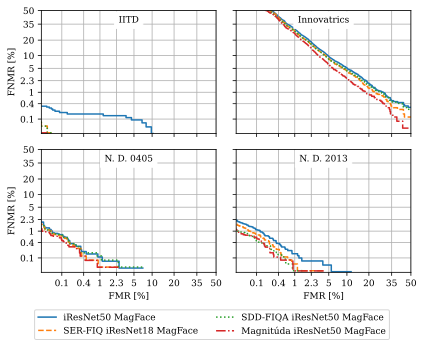

In [107]:
fig, auc = plot_dets_reject_rate('JnGKXb', 'iResNet50 MagFace', {
    '7B0TXb+serfiq' : 'SER-FIQ iResNet18 MagFace',
    'BnkOXb' : 'SDD-FIQA iResNet50 MagFace @ IIR=10%',
    'JnGKXb+magnitude' : 'Magnitúda iResNet50 MagFace @ IIR=10%',
}, fontsize=9, iir= 0.1, offset_legend=0.10, ncol=2)
table_fmt(auc)

7B0TXb
RecognitionNet-iresnet18-MagFaceLoss-YuBXXb : iResNet18, crop, without fully connected layer
    7B0TXb 0.6224066390041494 % 0.5260521042084169 %
    7B0TXb 80.73260073260073 % 81.36288998357963 %
    7B0TXb 4.6875 % 4.80225988700565 %
    7B0TXb 4.114002478314746 % 4.133804732118575 %
RecognitionNet-magiresnet18-MagFaceLoss-7B0TXb : Showcase of wrong schedule settings
    7B0TXb 0.6224066390041494 % 0.20130850528434827 %
    7B0TXb 80.73260073260073 % 80.09728415079044 %
    7B0TXb 4.6875 % 3.705195328231978 %
    7B0TXb 4.114002478314746 % 3.2187070151306743 %
RecognitionNet-iresnet50-MagFaceLoss-DaqKXb : Crop baseline with MagFace, without fully connected layer


KeyError: 'iris_verification_iitd_01_01+DaqKXb+serfiq'

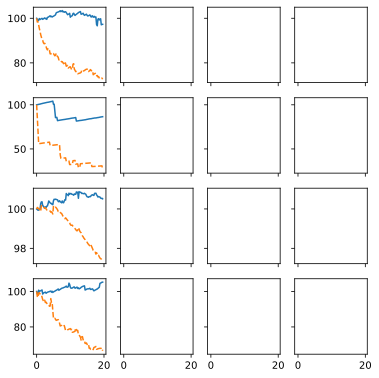

In [12]:
fig =  irrs_for_baselines({
    'DaqKXb' : 'iResNet50 AVG MagFace',
    'JnGKXb' : 'iResNet50 MagFace',
    '7B0TXb' : 'iResNet18 MagFace',
    'PUXTXb' : 'MobileNetV3 MagFace',

}, {
    'YuBXXb+serfiq' : 'SER-FIQ iResNet18 AVG MagFace',
    '7B0TXb+serfiq' : 'SER-FIQ iResNet18 MagFace',
    'DaqKXb+serfiq' : 'SER-FIQ iResNet50 AVG MagFace',
    'JnGKXb+serfiq' : 'SER-FIQ iResNet50 MagFace',
    'PUXTXb+serfiq' : 'SER-FIQ MobileNetV3 MagFace',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.17
)
fig.savefig('plots/irrs_serfiq_0.pdf')

{'JnGKXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}, 'PUXTXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}, 'xjxTXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}}
JnGKXb
SddFiqaNet-iresnet50-BnkOXb : SDDFIQA with labels from DaqKXb, with labels from iResNet50 crop without fc
SddFiqaNet-iresnet50-UeIWXb : SDDFIQA with labels from PUXTXb, with labels fomr MobileNetV3
SddFiqaNet-iresnet50-e9KWXb : SDDFIQA with labels from xjxTXb, small magiresnet18
PUXTXb
SddFiqaNet-iresnet50-BnkOXb : SDDFIQA with

/tmp/ipykernel_9843/3906529460.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{t:.0f}' for t in ax.get_xticks()], fontsize=fontsize, fontname=fontname)


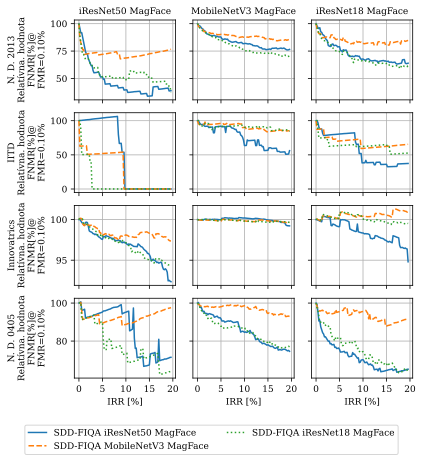

In [ ]:
fig =  irrs_for_baselines({
    'JnGKXb' : 'iResNet50 MagFace',
    'xjxTXb' : 'iResNet18 MagFace',
    'PUXTXb' : 'MobileNetV3 MagFace',
}, {
    'BnkOXb' : 'SDD-FIQA iResNet50 MagFace',
    'UeIWXb' : 'SDD-FIQA MobileNetV3 MagFace',
    'e9KWXb' : 'SDD-FIQA iResNet18 MagFace',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.17
)
fig.savefig('plots/irrs_sddfiqa_0.pdf')

{'JnGKXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}, 'PUXTXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}, 'xjxTXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}}
JnGKXb
RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop baseline
RecognitionNet-magiresnet18-MagFaceLoss-xjxTXb : Showcase of good schedule setting
RecognitionNet-mobilenetv3_large-MagFaceLoss-PUXTXb : Small MobileNetV3, baseline crop, without fully connected layer
PUXTXb
RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb : Crop base

/tmp/ipykernel_9843/3906529460.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{t:.0f}' for t in ax.get_xticks()], fontsize=fontsize, fontname=fontname)


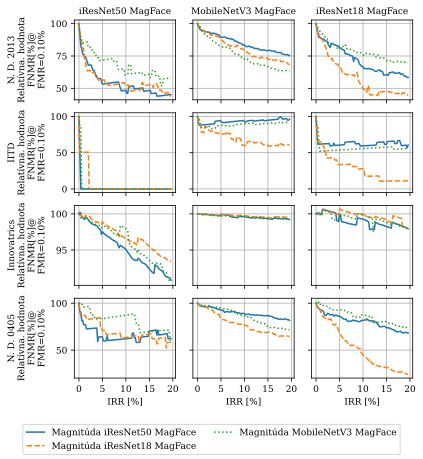

In [ ]:
fig =  irrs_for_baselines({
    'JnGKXb' : 'iResNet50 MagFace',
    'xjxTXb' : 'iResNet18 MagFace',
    'PUXTXb' : 'MobileNetV3 MagFace',
}, {
    'JnGKXb+magnitude' : 'Magnitúda iResNet50 MagFace',
    'xjxTXb+magnitude' : 'Magnitúda iResNet18 MagFace',
    'PUXTXb+magnitude' : 'Magnitúda MobileNetV3 MagFace',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.17
)
fig.savefig('plots/irrs_magface_0.pdf')

DaqKXb
PfeNet-iresnet50-3wDNXb : PFE with ArcFace
    DaqKXb 0.9681881051175657 % 0.6797583081570997 %
    DaqKXb 97.14285714285714 % 97.04811969268096 %
    DaqKXb 6.686046511627906 % 6.5103113627173474 %
    DaqKXb 5.8983890954151175 % 5.524861878453039 %
PfeNet-iresnet50-RyENXb : PFE with MagFace
    DaqKXb 0.9681881051175657 % 0.8252063015753939 %
    DaqKXb 97.14285714285714 % 96.95245835026412 %
    DaqKXb 6.686046511627906 % 6.529774127310062 %
    DaqKXb 5.8983890954151175 % 5.193370165745857 %
UVyKXb
PfeNet-iresnet50-3wDNXb : PFE with ArcFace
    UVyKXb 4.840940525587829 % 4.783484390735146 %
    UVyKXb 98.82783882783883 % 98.8273352203801 %
    UVyKXb 22.420058139534884 % 21.835826930853212 %
    UVyKXb 15.192069392812888 % 14.861878453038674 %
PfeNet-iresnet50-RyENXb : PFE with MagFace
    UVyKXb 4.840940525587829 % 4.3760940235058765 %
    UVyKXb 98.82783882783883 % 98.82161722876879 %
    UVyKXb 22.420058139534884 % 21.88911704312115 %
    UVyKXb 15.192069392812888 % 14.75

/tmp/ipykernel_9843/884519021.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{t:.0f}' for t in ax.get_xticks()], fontsize=fontsize, fontname=fontname)


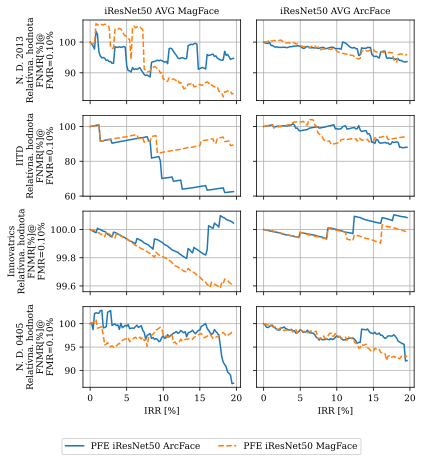

In [ ]:
fig =  irrs_for_baselines({
'UVyKXb' : 'iResNet50 AVG ArcFace',
'DaqKXb' : 'iResNet50 AVG MagFace',
#'JnGKXb' : 'iResNet50 MagFace',
#'arzKXb' : 'iResNet50 ArcFace',
}, {
    '3wDNXb' : 'PFE iResNet50 ArcFace',
    'RyENXb' : 'PFE iResNet50 MagFace',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.15
)
fig.savefig('plots/irrs_pfe_0.pdf')

JnGKXb
PfeNet-iresnet50-3wDNXb : PFE with ArcFace
    JnGKXb 0.18441678192715535 % 0.050352467270896276 %
    JnGKXb 59.853479853479854 % 60.6550748079256 %
    JnGKXb 0.7630813953488371 % 0.646987464617873 %
    JnGKXb 1.1152416356877324 % 0.8839779005524863 %
PfeNet-iresnet50-RyENXb : PFE with MagFace
    JnGKXb 0.18441678192715535 % 0.2000500125031258 %
    JnGKXb 59.853479853479854 % 59.97561966680212 %
    JnGKXb 0.7630813953488371 % 0.7802874743326489 %
    JnGKXb 1.1152416356877324 % 1.1049723756906076 %
PUXTXb
PfeNet-iresnet50-3wDNXb : PFE with ArcFace
    PUXTXb 2.18994928538497 % 1.9889224572004027 %
    PUXTXb 93.73626373626374 % 93.97492923574605 %
    PUXTXb 9.011627906976743 % 8.451273756570966 %
    PUXTXb 8.302354399008674 % 7.900552486187845 %
PfeNet-iresnet50-RyENXb : PFE with MagFace
    PUXTXb 2.18994928538497 % 2.250562640660165 %
    PUXTXb 93.73626373626374 % 93.82364892320196 %
    PUXTXb 9.011627906976743 % 8.213552361396303 %
    PUXTXb 8.302354399008674 % 7.8

/tmp/ipykernel_9843/884519021.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{t:.0f}' for t in ax.get_xticks()], fontsize=fontsize, fontname=fontname)


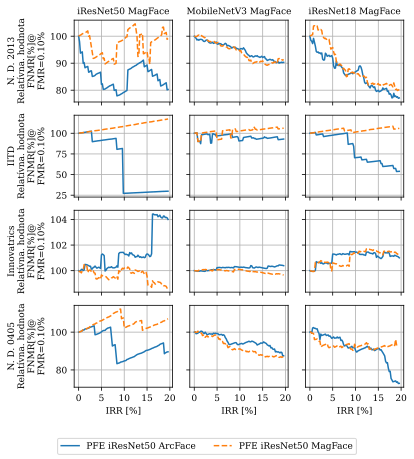

In [ ]:
fig =  irrs_for_baselines({
    'JnGKXb' : 'iResNet50 MagFace',
    'xjxTXb' : 'iResNet18 MagFace',
    'PUXTXb' : 'MobileNetV3 MagFace',
}, {
    '3wDNXb' : 'PFE iResNet50 ArcFace',
    'RyENXb' : 'PFE iResNet50 MagFace',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.15
)
fig.savefig('plots/irrs_pfe_1.pdf')

JnGKXb
PfeNet-magiresnet18-6MrZXb : PFE with iresnet18 MagFace


KeyError: 'iris_verification_iitd_01_01+6MrZXb'

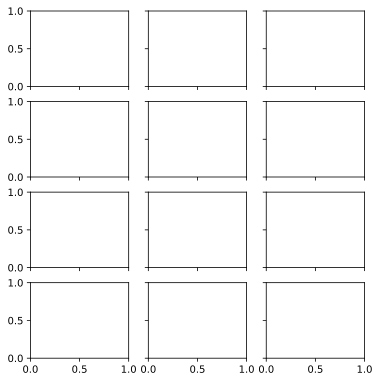

In [ ]:
fig =  irrs_for_baselines({
    'JnGKXb' : 'iResNet50 MagFace',
    'xjxTXb' : 'iResNet18 MagFace',
    'PUXTXb' : 'MobileNetV3 MagFace',
}, {
    '6MrZXb' : 'PFE iResNet18 MagFace',
    '8KuZXb' : '',
    'QTsZXb' : '',
    'cWqZXb' : '',
    '3wDNXb' : 'PFE iResNet50 ArcFace',
    'RyENXb' : 'PFE iResNet50 MagFace',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.15
)
fig.savefig('plots/irrs_pfe_2.pdf')

JnGKXb
CrFiqaNet-iresnet18-CrFiqaLoss-imOXXb : Trained well, gives results, certainty ratio
    JnGKXb 0.18441678192715535 % 0.0 %
    JnGKXb 59.853479853479854 % 57.445077298616766 %
    JnGKXb 0.7630813953488371 % 0.6843800322061192 %
    JnGKXb 1.1152416356877324 % 0.7664932931836846 %
CrFiqaNet-iresnet50-CrFiqaLoss-GzGNXb : Trained well, gives results, certainty ratio
    JnGKXb 0.18441678192715535 % 0.02509410288582183 %
    JnGKXb 59.853479853479854 % 57.701711491442545 %
    JnGKXb 0.7630813953488371 % 0.5661140315406389 %
    JnGKXb 1.1152416356877324 % 0.49396267837541163 %
CrFiqaNet-mobilenetv3_large-CrFiqaLoss-0IRWXb : Trained well, certainty ratio
    JnGKXb 0.18441678192715535 % 0.07436787307882994 %
    JnGKXb 59.853479853479854 % 57.183673469387756 %
    JnGKXb 0.7630813953488371 % 0.6127450980392157 %
    JnGKXb 1.1152416356877324 % 0.7421660252886202 %
PUXTXb
CrFiqaNet-iresnet18-CrFiqaLoss-imOXXb : Trained well, gives results, certainty ratio
    PUXTXb 2.1899492853849

/tmp/ipykernel_9843/884519021.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{t:.0f}' for t in ax.get_xticks()], fontsize=fontsize, fontname=fontname)


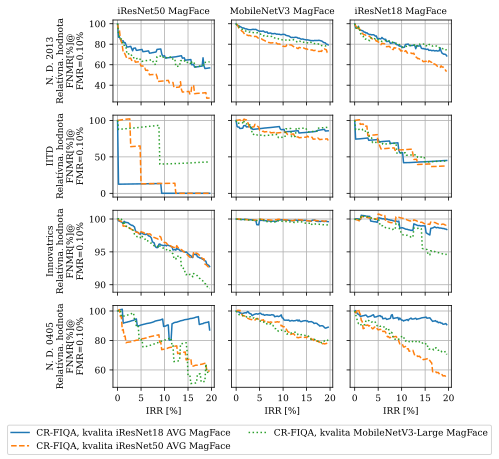

In [ ]:
fig =  irrs_for_baselines({
    'JnGKXb' : 'iResNet50 MagFace',
    'xjxTXb' : 'iResNet18 MagFace',
    'PUXTXb' : 'MobileNetV3 MagFace',
}, {
'imOXXb': 'CR-FIQA, kvalita iResNet18 AVG MagFace',
'GzGNXb': 'CR-FIQA, kvalita iResNet50 AVG MagFace',
'0IRWXb': 'CR-FIQA, kvalita MobileNetV3-Large MagFace',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.15
)
fig.savefig('plots/irrs_crfiqa_0.pdf')

In [ ]:
fig =  irrs_for_baselines({
'imOXXb': 'CR-FIQA\niResNet18 AVG\nMagFace',
'GzGNXb': 'CR-FIQA\niResNet50 AVG\nMagFace',
'0IRWXb': 'CR-FIQA\nMobileNetV3-Large\nMagFace',
}, {
'imOXXb': 'CR-FIQA, kvalita iResNet18 AVG MagFace',
'GzGNXb': 'CR-FIQA, kvalita iResNet50 AVG MagFace',
'0IRWXb': 'CR-FIQA, kvalita MobileNetV3-Large MagFace',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.15
)
fig.savefig('plots/irrs_crfiqa_1.pdf')

{'7B0TXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}, 'JnGKXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}, 'PUXTXb': {'iris_verification_NDCSI2013_01_05': <AxesSubplot:>, 'iris_verification_iitd_01_01': <AxesSubplot:>, 'iris_verification_inno_keymaker_01_01': <AxesSubplot:>, 'iris_verification_nd_0405_01_01': <AxesSubplot:>}}
7B0TXb
DfsNet-0G8VXb : Refernce with 640x480 input
DfsNet-XSkYXb : CX2 Reference with 640x480 input
DfsNet-hdpNXb : Reference with 224x244 input
DfsNet-R4kYXb : CX2 Reference with 224x244 input
JnGKXb
DfsNet-0G8VXb : Refernce with 640x480 input
DfsNet-XSkYXb : CX2 Reference with 640x480 input
DfsNet-hdpNXb : Reference with 224x244 inp

/tmp/ipykernel_9843/3906529460.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{t:.0f}' for t in ax.get_xticks()], fontsize=fontsize, fontname=fontname)


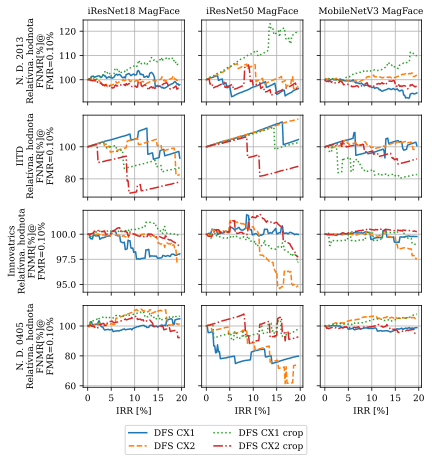

In [ ]:
fig =  irrs_for_baselines({
'JnGKXb' : 'iResNet50 MagFace',
'7B0TXb' : 'iResNet18 MagFace',
'PUXTXb' : 'MobileNetV3 MagFace',
}, {
    '0G8VXb' : 'DFS CX1',
    'XSkYXb' : 'DFS CX2',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.15
)
fig.savefig('plots/irrs_dfs.pdf')

In [ ]:
fig =  irrs_for_baselines({
'JnGKXb' : 'iResNet50 MagFace',
'7B0TXb' : 'iResNet18 MagFace',
'PUXTXb' : 'MobileNetV3 MagFace',
}, {
    '0G8VXb' : 'DFS CX1',
    'XSkYXb' : 'DFS CX2',
}, {
    'iris_verification_NDCSI2013_01_05': 0.001,
    'iris_verification_nd_0405_01_01': 0.001,
    'iris_verification_inno_keymaker_01_01': 0.001,
    'iris_verification_iitd_01_01': 0.001,
}, fontsize=9, offset_legend=0.15
)
fig.savefig('plots/irrs_dfs.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'runs_mnt/RecognitionNet-magiresnet18-MagFaceLoss-7B0TXb/csvs/metrics.csv'

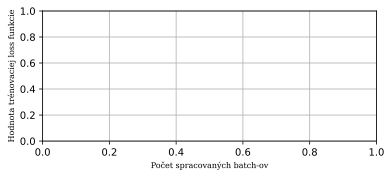

In [ ]:
setting = {'7B0TXb' : 'Správne nastavený plánovač MultiStepLR',
'xjxTXb' : 'Zle nastavený plánovač MultiStepLR'}

fig, ax = plt.subplots(1, 1, figsize=(CM_TO_INCH*15, CM_TO_INCH*6))
ax.set_xlabel('Počet spracovaných batch-ov', fontsize=8, fontname='DejaVu Serif')
ax.set_ylabel('Hodnota trénovaciej loss funkcie', fontsize=8, fontname='DejaVu Serif')
ax.grid()
for s in setting.keys():
    runname = comments[s.split('+')[0]][0]
    runpath = f'runs_mnt/{runname}/csvs/metrics.csv'
    df = pd.read_csv(runpath)
    df = df[['step', 'train_loss']].dropna()
    if s == 'xjxTXb':
        df[df['step'] > 7500] = df[df['step'] > 7500] + 1.8
    df = df[ df['step'] < 19000]
    ax.plot(df['step'], df['train_loss'], label=setting[s], linestyle='-')
for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.label.set_fontname('DejaVu Serif')
    tick.label.set_fontsize(8)
ax.legend(prop={'family':"DejaVu Serif", 'size':8})
fig.tight_layout()
fig.savefig('plots/learning_rate.pdf')

In [7]:
from lightning.dataset import IrisDatasetBase
from PIL import Image, ImageDraw
import torchvision.transforms as T
import torch
import pandas as pd

In [4]:
ds_root = '../Datasets/train_iris_utris_v1/'
df = pd.read_csv(os.path.join(ds_root, 'annotations.csv'))
df_sample = df.sample(frac=1).iloc[:9]
header = list(df.columns.values)

In [5]:
print(header)

['Unnamed: 0', 'confidence', 'db_id', 'detection_info', 'eye_side', 'fold', 'image_container_path', 'image_id', 'pos_x', 'pos_y', 'quality', 'radius_0', 'radius_1', 'subject_id', 'validity']


In [6]:
t = T.ToPILImage()
for i, img in enumerate(df_sample.iterrows()):
    header = img[1].keys().tolist()
    params = img[1].values.tolist()
    img_path = os.path.join('../Datasets/train_iris_utris_v1/', img[1]['image_id'], 'iris_right.UNKNOWN')
    newpath = f'plots/utiris_{i}'

    pic = Image.open(img_path)
    pic.save(f'{newpath}_original.jpg')

    point_radius=15
    pos_x = float(img[1]['pos_x'])
    pos_y = float(img[1]['pos_y'])
    radius_0 = float(img[1]['radius_0'])
    radius_1 = float(img[1]['radius_1'])

    pic_crop = IrisDatasetBase.crop(pic, pos_x, pos_y, radius_1)
    pic_crop_tensor = IrisDatasetBase.to_tensor(pic_crop)
    pic_unwrap = IrisDatasetBase.unwrap(pic_crop_tensor, radius_1)
    pic_unwrap = t(pic_unwrap)

    image_draw = ImageDraw.Draw(pic)
    image_draw.ellipse((
        pos_x-point_radius,
        pos_y-point_radius,
        pos_x+point_radius,
        pos_y+point_radius),
    fill='red')
    image_draw.ellipse((
        pos_x-radius_0,
        pos_y-radius_0,
        pos_x+radius_0,
        pos_y+radius_0), 
    outline ='blue', width=point_radius)
    image_draw.ellipse((
        pos_x-radius_1,
        pos_y-radius_1,
        pos_x+radius_1,
        pos_y+radius_1), 
    outline ='green', width=point_radius)
    
    pic.save(newpath+'.jpg')
    pic_crop.save(newpath+'_crop.jpg')
    pic_unwrap.save(newpath+'_unwrap.jpg')

    #shutil.copy(img_path, f'plots/utiris_{i}.jpg')

In [55]:
rand_t = T.Compose([
    T.ConvertImageDtype(torch.float),
    T.RandomAffine(degrees=10, fill=0, scale=(0.66, 1.33), shear=10, translate=(0.3,0.3)),
    T.Resize(size= (224, 224)),
    T.RandomAdjustSharpness(p=0.5, sharpness_factor=3),
    T.RandomAutocontrast(p=0.5),
    T.RandomInvert(p=0.5),
    #T.Normalize(mean=[0.5], std=[0.25]),
    T.RandomErasing(inplace=False, p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
    T.ToPILImage()
])
        

In [56]:
for i in range(16):
    rand_t(pic_crop_tensor).save(f'plots/utiris_{i}_rand.jpg')

In [82]:
print('Loading mobilenet...')
model_mobilenet = torch.load("runs_mnt/RecognitionNet-mobilenetv3_large-MagFaceLoss-PUXTXb/encoder-RecognitionNet-mobilenetv3_large-MagFaceLoss-PUXTXb.pickle")
print('Loading iresnet18...')
model_iresnet18 = torch.load("runs_mnt/RecognitionNet-magiresnet18-MagFaceLoss-xjxTXb/encoder-RecognitionNet-magiresnet18-MagFaceLoss-xjxTXb.pickle")
print('Loading iresnet50...')
model_iresnet50 = torch.load("runs_mnt/RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb/encoder-RecognitionNet-magiresnet50-MagFaceLoss-JnGKXb.pickle")
print('Loading iresnet18_avg...')
model_iresnet18_avg = torch.load("runs_mnt/RecognitionNet-iresnet18-MagFaceLoss-YuBXXb/encoder-RecognitionNet-iresnet18-MagFaceLoss-YuBXXb.pickle")

In [83]:
print('mobilenet', sum(model_mobilenet[p].numel() for p in model_mobilenet))
print('iresnet18', sum(model_iresnet18[p].numel() for p in model_iresnet18))
print('iresnet50', sum(model_iresnet50[p].numel() for p in model_iresnet50))
print('iresnet18_avg', sum(model_iresnet18_avg[p].numel() for p in model_iresnet18_avg))

mobilenet 4882062
iresnet18 62572318
iresnet50 82161038
iresnet18_avg 11442516


In [84]:
62572318/4882062

12.816780696353304